In [ ]:
!pwd

/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf # tensorflow v2.11.0
import numpy as np

In [3]:
import re
from sklearn.preprocessing import OneHotEncoder
from typing import NamedTuple

EmbeddingShape = NamedTuple("EmbeddingShape", [("vocab_size", int), ("embedding_size", int)])
'''(NamedTuple) class for embedding shape contain vocab_size and embedding_size'''

class LogPreprocessor(object):
    """LogPreprocessor
    class for preprocessing data before feed to model
    
    Args:
        record_unknow (bool): whether recording unknown word from preprocessing process or not. Defaults to False.
    """
    
    def __init__(self, record_unknow=False) -> None:
        if record_unknow: 
            self.unknow_words = dict()
            '''dictionary for counting ocurred unknow word from preprocessing process where keys is word and value is occuring number'''
    
    @staticmethod
    def text_cleansing(text):
        """(static method) text_cleansing.
        method for cleansing log text.
        
        Args:
            text (str): log text to cleansing special character.

        Returns:
            str: cleansed log text.
        """
        regex_except_token = r'\B(?!<\w+>\B)[^\w\s]'
        regex_expect_words = r'[^\w<>]+'
        output = re.sub(regex_except_token, '', text)
        output = re.sub(regex_expect_words, ' ', output)
        return output
    
    def load_word2vec_format(self, 
                             file_path, 
                             unknow_token=None, 
                             unknow_repr=None):
        """(instance method) load_word2vec_format
        loading word2vec format file to extract embeadding metrix

        Args:
            file_path (str): file's path to word2vec format file (.txt)
            unknow_token (str, optional): word for represent unknown word (e.g. '<OOV>'). 
            Defaults to None.
            unknow_repr (_ArrayLike, optional): word vector for represent unknown word. 
            if 'unknow_repr' is not set but 'unknow_token' is set 
            it will use zero vector as unknow represent vector. Defaults to None.
        """
        with open(file_path, "r") as f:
            vec = dict()
            for l in f.readlines():
                data = list(filter(None, re.split(" +", l)))
                vec[data[0]] = np.array(data[1:], dtype=np.float32)
            
            f.close()
                
        embedding_size = int(vec.pop(list(vec.keys())[0])[0])
        if unknow_token is not None:
            try:
                unknow_vec = vec[unknow_token]
            except AttributeError:
                print(f"there's not '{unknow_token}' in dictionary.")
                if unknow_repr:
                    assert len(unknow_repr) == embedding_size, \
                        f"unknown represent vector must same shape with embedding size (expected {embedding_size}, got {len(unknow_repr)})"
                else:
                    unknow_repr = [ 0 for _ in range(embedding_size) ]
                vec[unknow_token] = unknow_repr
            self.unknow_token = unknow_token
        else: 
            self.unknow_token = None
        
        vocab_size = len(vec.keys())    
        self.word_vectors = np.array(list(vec.values()))
        self.words_indices = { word: i for i, word in enumerate(vec.keys()) }
        self.embedding_shape = EmbeddingShape(vocab_size, embedding_size)
    
    def indice_encode(self, line):
        """(instance method) indice_encode.
        encoding string words in log line to index number.

        Args:
            line (_ArrayLike[str]): array of tokenized string line.

        Returns:
            List[int]: list contains index number.
        """
        record_unknow = hasattr(self, "unknow_words")
        encoded = list()
        
        
        for word in line:
            try:
                i = self.words_indices[word]
            except KeyError:
                if record_unknow:
                    if word in self.unknow_words.keys(): self.unknow_words[word] += 1
                    else: self.unknow_words[word] = 0
                
                if self.unknow_token is None: continue
                else: i = self.words_indices[self.unknow_token]
            encoded.append(i)

            
        return encoded
    
    def insert_new_word(self, word, vector, index=-1):
        """(instance method) insert_new_word
        insert a new word and vector to word dictionary at specified index
        
        Args:
            word (str): new word to insert
            vector (_ArrayLike[Float]): new vector to insert
            index (int, optional): insert at index if negative index will insert at (vocab_size + index + 1). Defaults to -1.
        """
        if index < 0: index = self.embedding_shape.vocab_size + index + 1
        assert word not in self.words_indices.keys(), \
            f"there is already exist input word in vocab at {self.words_indices[word]} index"
        assert np.ndim(vector) == 1, \
            f"expect 1 dim vector as a input but got {np.ndim(vector)}."
        assert len(vector) == self.embedding_shape.embedding_size, \
            f"insert vector's shape must match to embedding size. (got {np.shape(vector)})"
            
        new_word_vectors = np.insert(self.word_vectors, index, vector, axis=0)
        new_words_indices = { k: v if v < index else v + 1 for k, v in self.words_indices.items() }
        new_words_indices[word] = index
        new_embedding_shape = EmbeddingShape(self.embedding_shape.vocab_size + 1, self.embedding_shape.embedding_size)
        
        self.word_vectors = new_word_vectors
        self.words_indices = new_words_indices
        self.embedding_shape = new_embedding_shape
    
    def indice_padding(self, batch, padding_token, padding_size=0):
        """(instance method) indice_padding.
        padding tokenized array in batch by index number of padding_token.
        
        Args:
            batch (_ArrayLike[_ArrayLike[int]]): data batch of array of index number.
            padding_token (str): word for represent padding token (e.g. "<PADDING>") where padding token must in dictionary.
            padding_size (int, optional): size of output. if 'padding_size' is less than longest line in batch it will set to length of longest line is batch. Defaults to 0.

        Returns:
            NDArray[NDArray[int]]: array of padded batch data.
        """
        padding_idx = self.words_indices[padding_token]
        seq_length = np.array([ len(inst) for inst in batch ])
        max_length = seq_length.max()
        padding_size = max(padding_size, max_length)
        
        padding_batch = np.array([ np.pad(inst, (0, padding_size - len(inst)), constant_values=padding_idx) for inst in batch ])
        return padding_batch
    
    @staticmethod
    def build_label(y, classes=None):
        """(static method) build_label
        build labels array using one-hot encoding

        Args:
            y (_ArrayLike): input labels
            classes (_ArrayLike, optional): array contains all classes. if None, it will set to unique label of input. Defaults to None.

        Returns:
            _Array[_Array[int]]: array of one-hot label where shape is (input_size, num_classes)
        """
        if classes is None:
            classes = np.unique(y)
            
        encoder = OneHotEncoder(categories=[classes])
        return encoder.fit_transform(y).toarray()

In [4]:
prep = LogPreprocessor()
# extract word2vec format file to embedding matrix and words indice
# change this path for select another embedding method
fine_tune_files = "/content/drive/MyDrive/Colab Notebooks/word2Vec/BGL-word2vec-fine-tune-embedder-no-parameter-labeling.txt"
prep.load_word2vec_format(fine_tune_files)
# insert "<PAD>" at first index of embedding matrix with zeros vector
# if padding token is represented as zeros vector, unknown token must be represented
# as non-zeros vector. (that mean if you set unknow_token for load_word2vec_format you
# have to set unknow_repr too or using non-zero vector for represent padding token).
prep.insert_new_word("<PAD>", np.zeros(prep.embedding_shape.embedding_size), index=0)

In [16]:
import pandas as pd
pkl_dir = "/content/drive/MyDrive/Colab Notebooks/BGL_preprocessed_type2/processed_<*>"
# load processed trainset of structured log and template log data
prep_train_struc_log = pd.read_pickle(pkl_dir + "/log_structured.trainset.pkl")
prep_train_templ_log = pd.read_pickle(pkl_dir + "/log_template.trainset.pkl")

# encode token to index of embedding matrix
prep_train_struc_log["Token_Indice_encoded"] = prep_train_struc_log.Token.map(prep.indice_encode)
# padding token with "<PAD>"
padd_input = prep.indice_padding(prep_train_struc_log["Token_Indice_encoded"], "<PAD>")
# build label array to one hot format
label = prep.build_label(prep_train_struc_log["Label"].to_numpy().reshape((-1, 1)), classes=[0, 1])
# you also can use this preprocessing pipeline for testset

prep_test_struc_log = pd.read_pickle(pkl_dir + "/log_structured.testset.pkl")
prep_test_templ_log = pd.read_pickle(pkl_dir + "/log_structured.testset.pkl")

prep_test_struc_log["Token_Indice_encoded"] = prep_test_struc_log.Token.map(prep.indice_encode)

padd_test_input = prep.indice_padding(prep_test_struc_log["Token_Indice_encoded"], "<PAD>")

test_label = prep.build_label(prep_test_struc_log["Label"].to_numpy().reshape((-1, 1)), classes=[0, 1])


In [17]:
prep_test_struc_log["EventTemplate"][prep_test_struc_log["Token"].isna()]

Series([], Name: EventTemplate, dtype: object)

In [18]:
class TextCNNConfig():
    """class for containing config of TextCNN model
    """
    
    def __init__(self,
                num_classes,
                vocab_size,
                embedding_size, 
                filter_sizes, 
                num_filters,
                sequence_length=None,
                dropout_rate=None,
                l2_reg_lambda=0.0,
                seed=42,
                pretrain_embedding_matrix=None
                ) -> None:
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.sequence_length = sequence_length
        self.dropout_rate = dropout_rate
        self.l2_reg_lambda = l2_reg_lambda
        self.seed = seed
        self.pretrain_embedding_matrix = pretrain_embedding_matrix
       
    def __repr__(self):
        return "TextCNNConfig:\n" +\
            f"num_classes:      {self.num_classes}\n" +\
            f"vocab_sizes:      {self.vocab_size}\n" +\
            f"embedding_size:   {self.embedding_size}\n" +\
            f"filter_sizes:     {self.filter_sizes}\n" +\
            f"num_filters:      {self.num_filters}\n" +\
            f"sequence_length:  {self.sequence_length}\n" +\
            f"dropout_rate:     {self.dropout_rate}\n" +\
            f"l2_reg_lambda:    {self.l2_reg_lambda}\n" +\
            f"seed:             {self.seed}\n" +\
            f"pretrain_embedding_matrix's shape: {np.shape(self.pretrain_embedding_matrix) if self.pretrain_embedding_matrix is not None else 'None'}"

class TextCNN(object):
    """CNN model for NLP task presented by Kim Y. in 2014 " Convolutional Neural Networks for Sentence Classification"

    Args:
        num_classes (int): number of classes for classification.
        vocab_size (int): number of known vocabularies. if pretrain_embedding_matrix is set, vocab_size must rely on pretrain_embedding_matrix' shape.
        embedding_size (int): length of embedding vector. if pretrain_embedding_matrix is set, embedding_size must rely on pretrain_embedding_matrix' shape.
        filter_sizes (_ArrayLike[int]): array contain convolution filter height.
        num_filters (int): number of each filter size.
        sequence_length (int, optional): length of input sequence. if None, input can be any length. Defualts is None.
        dropout_rate (float, optionanl): dropout rate for dropout layer. if None, model will not include dropout layer. Defualts is None.
        l2_reg_lambda (float, optional): L2 regularization factor for dense layer. Defaults is 0.0
        seed (int, optional): random seed. Defaults is 42.
        pretrain_embedding_matrix (_2DArray[float]): pretained embedding vectors. if None, embedding matrix will be initialized by random and it will be trained while trainning else it will be not trainable. Defaults is None
    """
    
    def __init__(self,
        num_classes,
        vocab_size,
        embedding_size, 
        filter_sizes, 
        num_filters,
        sequence_length=None,
        dropout_rate=None,
        l2_reg_lambda=0.0,
        seed=42,
        pretrain_embedding_matrix=None
        ) -> None:
        
        self.config = TextCNNConfig(
            num_classes,
            vocab_size,
            embedding_size, 
            filter_sizes, 
            num_filters,
            sequence_length,
            dropout_rate,
            l2_reg_lambda,
            seed,
            pretrain_embedding_matrix
        )
        
        # set global random seed
        if seed is not None: tf.random.set_seed(seed)
        # define input layer where input shape is (batch_size, sequence_length)
        # input data is 2d-array which each value is index of jth word's word vector 
        # in embedding metrix of ith line.
        input_word_idx = tf.keras.layers.Input(
            shape=(sequence_length,),
            dtype=tf.dtypes.int32,
            name="input-word-idx-layer"
        )
        
        # if pretrain_embedding_matrix is not defined, using random uniform for 
        # initailize embedding matrix
        embed_trainable = pretrain_embedding_matrix is None
        if pretrain_embedding_matrix is None:
            embed_initializers = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        else:
            pretrain_embedding_matrix = np.array(pretrain_embedding_matrix)
            assert (vocab_size, embedding_size) == pretrain_embedding_matrix.shape, \
                f"shape of embedding_matrix must match to vocab_size and embedding_size (expect {(vocab_size, embedding_size)}, got {pretrain_embedding_matrix.shape})."
            embed_initializers = tf.keras.initializers.Constant(pretrain_embedding_matrix)
        # the embedding layer will defaultly use GPU memory
        # so to avoid error while trainning from optimizer which not support GPU
        # using tf.device("cpu:0") to place embedding matrix on CPU memory
        with tf.name_scope("embedding"), tf.device("cpu:0"):
            # define embedding layer where in put is array of index of word's vector in
            # embedding matrix. the output's shape is 
            # (batch_size, sequence_length, embedding_size)
            embed = tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=embedding_size,
                embeddings_initializer=embed_initializers,
                input_length=sequence_length,
                trainable=embed_trainable,
                name="embedding-layer"
            )(input_word_idx)
            # define reshape layer for expand dimention of output from embedding layer to
            # (batch_size, sequence_length, embedding_size, 1) for suit to input of
            # 2d convolution layer which require input shape as 
            # (batch_size, weight, height, channel)
            expand_dim_embed = tf.keras.layers.Reshape(
                target_shape=(-1, embedding_size, 1),
                name="reshape-expand-dim-layer"
                )(embed)
        
        features = list() # list for contain output of each pooling layer
        with tf.name_scope("convolution"):
            # for loop to define each convolution layer of each size of the filter
            for size in filter_sizes:
                # define 2d convolution layer of n(num_filters) filters with kernel size
                # is (size, embedding_size) strides by (1, 1) and not use padding.
                # using ReLu as activation function also use bias. output's shape of this
                # layer is (batch_size, sequence_length - size + 1, 1, num_filters)
                conv = tf.keras.layers.Conv2D(
                    filters=num_filters,
                    kernel_size=(size, embedding_size),
                    strides=(1, 1),
                    padding="valid",
                    activation="relu",
                    use_bias=True,
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                    bias_initializer=tf.keras.initializers.Constant(0.1),
                    name=f"conv-{size}_{embedding_size}-layer"
                )(expand_dim_embed)
                # define reshape layer for squeeze dimention of output from convolution layer 
                # to (batch_size, feature_map_height, num_filters)
                reshape = tf.keras.layers.Reshape(target_shape=(-1, num_filters), name=f"reshape-squeeze-{size}_{embedding_size}-layer")(conv)
                # define max-over-time pooling layer for extract max value from each 
                # feature map from convolution layers. where output is vector with 
                # shape of (batch_size, 1, num_filters)
                pooling = tf.keras.layers.GlobalMaxPool1D(name=f"global-max-pooling-{size}_{embedding_size}-layer")(reshape)
                # define flatten layer for shape output of pooling layer to 
                # (batch_size, num_filters)
                flatten_pooling = tf.keras.layers.Flatten(name=f"flatten-pooling-{size}_{embedding_size}-layer")(pooling)
                features.append(flatten_pooling)
        
        # define concatenate layer to concate all features for convolution & pooling 
        # process. where output shape is (batch_size, num_filters * len(filter_sizes))
        concat = tf.keras.layers.Concatenate(name="concatenate-layer")(features)
        
        # if dropout_rate is None, model will not include dropout layer
        if dropout_rate is not None:
            with tf.name_scope("dropout"):
                # define dropout layer with specified dropout_rate
                dropout = tf.keras.layers.Dropout(rate=dropout_rate)(concat)
                fc_input = dropout
        else: fc_input = concat
        
        with tf.name_scope("fully-connected"):
            # define output layer (fully connected layer) using Softmax as activation
            # and L2 as regularization method. where output is propability to be each 
            # class with output shape is (batch_size, num_classes).
            output = tf.keras.layers.Dense(
                units=num_classes,
                activation="softmax",
                use_bias=True,
                kernel_initializer=tf.keras.initializers.GlorotUniform(),
                bias_initializer=tf.keras.initializers.Constant(0.1),
                kernel_regularizer=tf.keras.regularizers.L2(l2=l2_reg_lambda),
                bias_regularizer=tf.keras.regularizers.L2(l2=l2_reg_lambda),
                name="output-layer"
                )(fc_input)
        
        # define model with all defined sequent layers
        self.model = tf.keras.Model(inputs=input_word_idx, outputs=output)
        

In [19]:
textcnn = TextCNN(
                num_classes=2,
                vocab_size=prep.embedding_shape.vocab_size,
                embedding_size=prep.embedding_shape.embedding_size,
                filter_sizes=[2, 3, 4],
                num_filters=2,
                sequence_length=None,
                dropout_rate=0.5,
                l2_reg_lambda=0.01,
                seed=42,
                pretrain_embedding_matrix=prep.word_vectors)

textcnn.config

TextCNNConfig:
num_classes:      2
vocab_sizes:      3000014
embedding_size:   300
filter_sizes:     [2, 3, 4]
num_filters:      2
sequence_length:  None
dropout_rate:     0.5
l2_reg_lambda:    0.01
seed:             42
pretrain_embedding_matrix's shape: (3000014, 300)

In [20]:
# compile model using Adam optimizer with learning rate equal to 0.001
# categorical crossentropy as loss function and evaluation metrics are
# precision and recall
textcnn.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)
textcnn.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-word-idx-layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 embedding-layer (Embedding)    (None, None, 300)    900004200   ['input-word-idx-layer[0][0]']   
                                                                                                  
 reshape-expand-dim-layer (Resh  (None, None, 300, 1  0          ['embedding-layer[0][0]']        
 ape)                           )                                                                 
                                                                                              

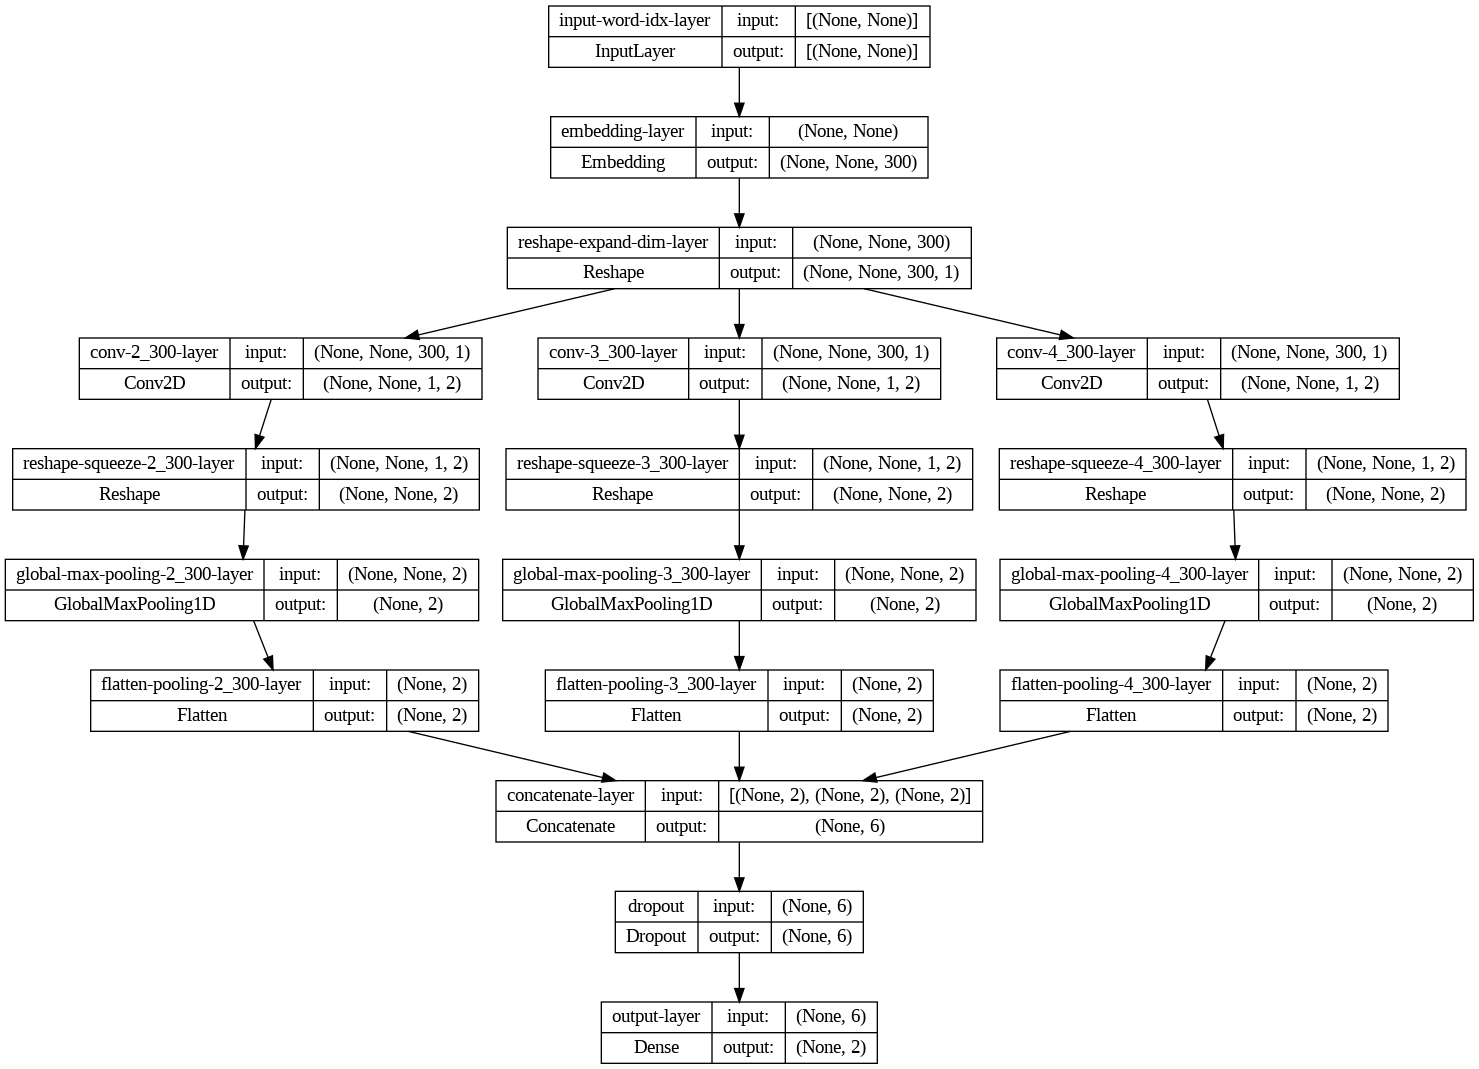

In [21]:
# Note: If you don't want to visualize model achitecture 
# ***** you don't need to run this cell just skip it.
# You must install pydot (`pip install pydot`) and install graphviz 
# (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
# (e.g. for mac) $ brew install graphviz
# (e.g. for win) $ winget install graphviz
tf.keras.utils.plot_model(textcnn.model, "textcnn_model.png", show_shapes=True)

In [22]:
hist = textcnn.model.fit(
    x=padd_input,
    y=label,
    batch_size=None,
    epochs=2,
    shuffle=False
)
hist.history

Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


461/461 [==============================] - 8s 10ms/step - loss: 0.1299 - precision: 0.9760 - recall: 0.9760
Epoch 2/2
461/461 [==============================] - 5s 10ms/step - loss: 0.0524 - precision: 1.0000 - recall: 1.0000


{'loss': [0.12986981868743896, 0.05239126458764076],
 'precision': [0.9759722948074341, 1.0],
 'recall': [0.9759722948074341, 1.0]}

In [31]:
textcnn.model.evaluate(
    x=padd_test_input,
    y=test_label
)

146837/146837 [==============================] - 2508s 17ms/step - loss: 0.4927 - precision: 0.9258 - recall: 0.9258


[0.4927484691143036, 0.9258400201797485, 0.9258400201797485]